# Assignment 01

## Part II - Binomial Tree

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from joblib import Parallel, delayed

In [2]:
def buildTree(S, vol, T, N):
    
    dt = T / N
    
    matrix = np.zeros((N+1, N+1))
    
    u = np.exp(vol * np.sqrt(T/N))
    d = np.exp(-vol * np.sqrt(T/N))
    
    # Iterate over the lower triangle
    for i in np.arange(N+1):
        for j in np.arange(i + 1):
            matrix[i,j] = S*(u**j)*(d**(i-j))

    return matrix

In [54]:
def valueOptionMatrix(tree, vol, T, r, K, option="call"):
    
    columns = tree.shape[1]
    rows = tree.shape[0] 
    
    dt = T/rows
    u = np.exp(vol *np.sqrt(dt))
    d = np.exp(-vol * np.sqrt(dt))
    p = (np.exp(r*dt) - d) / (u - d)
    assert 0<d<np.exp(r*dt)<u,  "the model doesn't work with these parameters"  
    
    option_matrix = np.zeros((rows, columns))
    
    # Walk backwards, we start in last row of the matrix
    # Add the payoff function in the last row
    for column in np.arange(columns):
        S = tree[rows - 1, column]
        option_matrix[rows - 1, column] =  S - K if S-K > 0 else 0
        if option == "put":
            option_matrix[rows - 1, column] =  K-S if K-S > 0 else 0
    
    # For a l l o t h e r rows , we need t o combine from p r e v i o u s rows
    # We walk backwards , from t h e l a s t row t o t h e f i r s t row
    for row in np.arange(rows - 1)[::-1]:
        for column in np.arange(row + 1):
            down = option_matrix[row + 1, column]
            up = option_matrix[row+1, column+1]
            option_matrix[row, column] = (up*p+down*(1-p)) * np.exp(-r*dt)
                
    return option_matrix

In [4]:
'''
Example from appendix
'''

r = 0.06
vol = 0.20
S = 100
T = 1
N = 50
tree = buildTree(S, vol, T, N)
valueOptionMatrix(tree, vol, T, r, 99)

array([[ 11.53347991,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  9.59175926,  13.39574461,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  7.85684611,  11.25404549,  15.45134913, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 289.94768907,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ..., 278.98502369,
        300.97665399,   0.        ],
       [  0.        ,   0.        ,   0.        , ..., 268.32487093,
        289.70286396, 312.32503788]])

In [5]:
'''
Study Convergence
'''
def run_sample(N):
    tree = buildTree(S, vol, T, N)
    return valueOptionMatrix(tree, vol, T, r, 99)[0][0]

In [116]:
ans = Parallel(n_jobs=12)(delayed(run_sample)(N = i)
                                      for i in np.arange(10,1000,5))


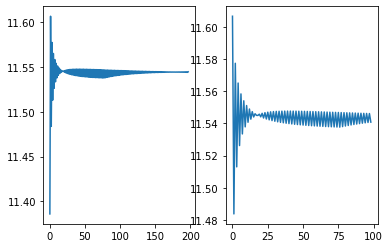

In [125]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(ans)
axes[1].plot(ans[1:100])

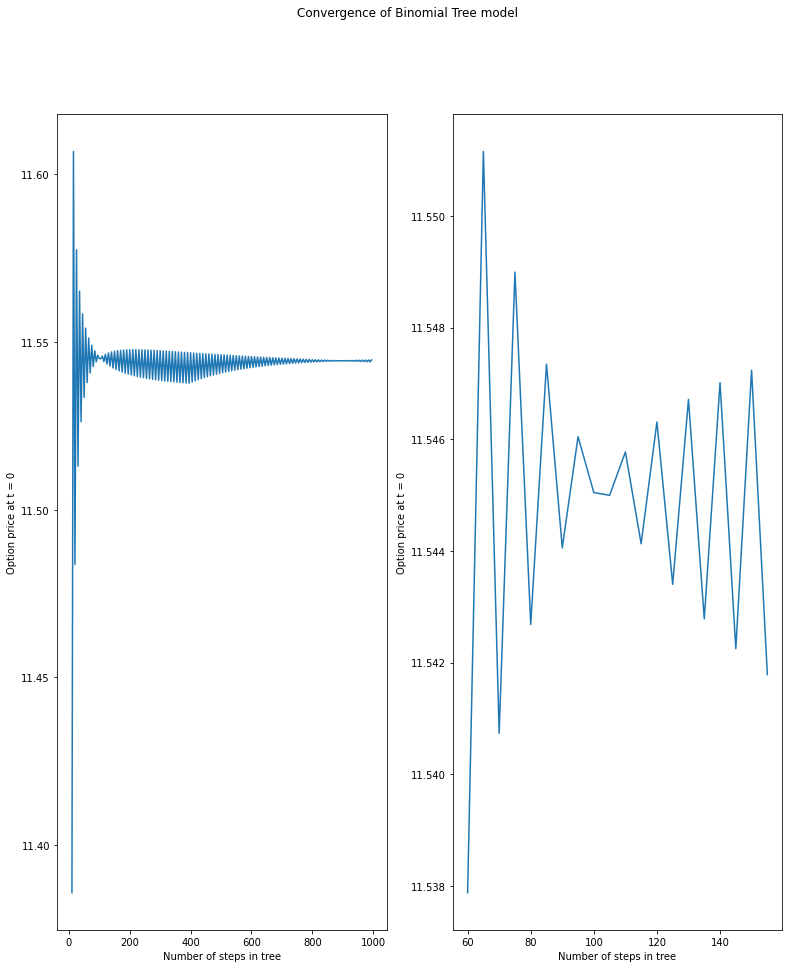

In [142]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,15))
axes[0].plot(np.arange(10,1000,5), ans)
axes[0].set_ylabel("Option price at t = 0")
axes[0].set_xlabel("Number of steps in tree")
fig.suptitle("Convergence of Binomial Tree model")

axes[1].plot(np.arange(10,1000,5)[10:30], ans[10:30])
axes[1].set_ylabel("Option price at t = 0")
axes[1].set_xlabel("Number of steps in tree")

plt.savefig()

In [8]:
"""
How many stocks to buy?
"""
def getStocks(vol):
    tree = buildTree(S, vol, T, 100)
    option_prices = valueOptionMatrix(tree, vol, T, r, 99)
    dt = T / N
    fu = option_prices[1][1]
    fd = option_prices[1][0]
    u = np.exp(vol *np.sqrt(dt))
    d = np.exp(-vol * np.sqrt(dt))
    S0 = 100
    return (fu -fd) / (S0*u - S0*d)

In [66]:
getStocks(5)

0.061546599248505134

In [75]:
ans = [getStocks(x) for x in np.linspace(0.01,1,100)]

Text(0.5, 0, 'Volatility')

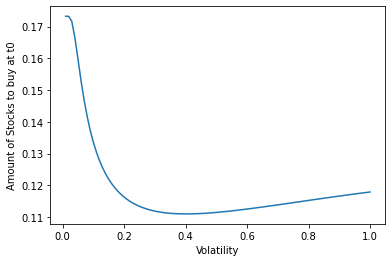

In [76]:
plt.plot(np.linspace(0.01,1,100),ans)
plt.ylabel("Amount of Stocks to buy at t0")
plt.xlabel("Volatility")

In [53]:
"""
American option
"""
def valueOptionMatrixAmerican(tree, vol, T, r, K, option="call"):
    
    columns = tree.shape[1]
    rows = tree.shape[0] 
    
    dt = T/rows
    u = np.exp(vol *np.sqrt(dt))
    d = np.exp(-vol * np.sqrt(dt))
    p = (np.exp(r*dt) - d) / (u - d)
    assert 0<d<np.exp(r*dt)<u, "the model doesn't work with these parameters" 
    option_matrix = np.zeros((rows, columns))
    
    # Walk backwards, we start in last row of the matrix
    # Add the payoff function in the last row
    for column in np.arange(columns):
        S = tree[rows - 1, column]
        option_matrix[rows - 1, column] =  S - K if S-K > 0 else 0
        if option == "put":
            option_matrix[rows - 1, column] =  K-S if K-S > 0 else 0
    
    # For a l l o t h e r rows , we need t o combine from p r e v i o u s rows
    # We walk backwards , from t h e l a s t row t o t h e f i r s t row
    for row in np.arange(rows - 1)[::-1]:
        for column in np.arange(row + 1):
            down = option_matrix[row + 1, column]
            up = option_matrix[row+1, column+1]
            discounted_value = (up*p+down*(1-p)) * np.exp(-r*dt)
            
            S = tree[row, column]
            value_execute = S - K if S-K > 0 else 0
            if option=="put":
                value_execute = K-S if K-S > 0 else 0

            option_matrix[row, column] = value_execute if value_execute>discounted_value else discounted_value
    return option_matrix

In [79]:
r = 0.06
vol = .2
S = 100
T = 1
N = 100
K = 99
tree = buildTree(S, vol, T, N)
europe = valueOptionMatrix(tree, vol, T, r, K)
europe_put = valueOptionMatrix(tree, vol, T, r, K, "put")
amrica = valueOptionMatrixAmerican(tree, vol, T, r, K)
amrica_put = valueOptionMatrixAmerican(tree, vol, T, r, K, "put")

In [80]:
europe

array([[ 11.54504564,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 10.17902937,  12.87118746,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  8.91485174,  11.40571643,  14.29444678, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 611.0558751 ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ..., 596.93664322,
        625.33595697,   0.        ],
       [  0.        ,   0.        ,   0.        , ..., 583.09584693,
        610.93270652, 639.90560989]])

In [81]:
europe_put

array([[ 4.7955865 ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 5.46631015,  4.15663523,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 6.19966526,  4.76795405,  3.57402516, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [84.79649259, 84.22163392, 83.62331483, ...,  0.        ,
         0.        ,  0.        ],
       [85.13422726, 84.57075378, 83.98428452, ...,  0.        ,
         0.        ,  0.        ],
       [85.46647168, 84.91415791, 84.33930379, ...,  0.        ,
         0.        ,  0.        ]])

In [82]:
amrica

array([[ 11.54504564,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 10.17902937,  12.87118746,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  8.91485174,  11.40571643,  14.29444678, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 611.0558751 ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ..., 596.93664322,
        625.33595697,   0.        ],
       [  0.        ,   0.        ,   0.        , ..., 583.09584693,
        610.93270652, 639.90560989]])

In [83]:
amrica_put

array([[ 5.35915401,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 6.1409692 ,  4.6141048 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 7.00422614,  5.31856865,  3.94251903, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [84.91415791, 84.33930379, 83.74098942, ...,  0.        ,
         0.        ,  0.        ],
       [85.19307627, 84.62960502, 84.04313808, ...,  0.        ,
         0.        ,  0.        ],
       [85.46647168, 84.91415791, 84.33930379, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
"""
Conclusion: 
 - American call and European calls are equal when there is no dividend
 - American out is more expensive than European puts

"""

In [101]:
"""
Volatility experiment
"""
def getSample(vol, option, style):
    tree = buildTree(S, vol, T, N)
    if style == "american":
        ans = valueOptionMatrixAmerican(tree, vol, T, r, K, option=option)
    else:
        ans = valueOptionMatrix(tree, vol, T, r, K, option=option)
    return ans[0][0]

In [103]:
puts = [getSample(x, "put", "american") for x in np.linspace(0.01,1, 100)]
calls = [getSample(x, "call", "american") for x in np.linspace(0.01,1, 100)]
puts_e = [getSample(x, "put", "eur") for x in np.linspace(0.01,1, 100)]
calls_e = [getSample(x, "call", "eur") for x in np.linspace(0.01,1, 100)]

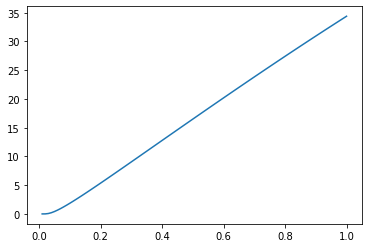

In [104]:
plt.plot(np.linspace(0.01,1, 100), puts)

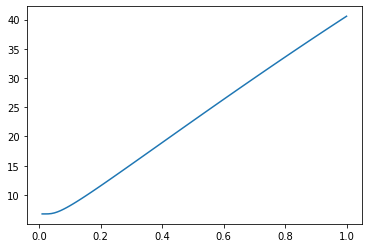

In [105]:
plt.plot(np.linspace(0.01,1, 100), calls)

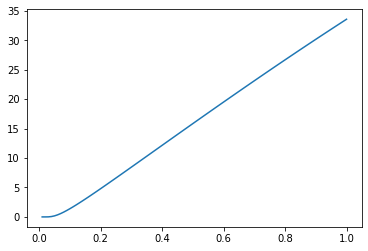

In [106]:
plt.plot(np.linspace(0.01,1, 100), puts_e)

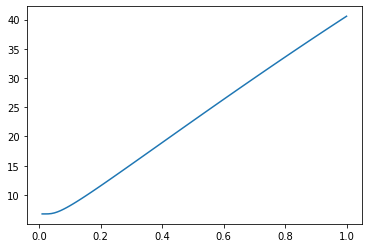

In [107]:
plt.plot(np.linspace(0.01,1, 100), calls_e)

## Black Scholes for European Call

In [7]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

In [8]:
r = 0.06
vol = 0.2
S = 100
T = 1
N = 3
K = 99

t = 0
tau = T - t

In [9]:
""" 
Black Scholes Model for European Call
"""

def Black_Scholes_Call(S, K, r, vol, tau):
    d1 = (np.log(S / K) + (r + ((vol**2)/2.)*tau)) / (vol*np.sqrt(tau))
    d2 = d1 - vol*np.sqrt(tau)

    V = S * norm.cdf(d1) - np.exp(-r*tau) * K * norm.cdf(d2)
    print('Black Scholes European Call Option Value: ', V)
    print('Black Scholes European Call Delta: ', d1)
    
    return V, d1

Black_Scholes_Call(S, K, r, vol, tau)

Black Scholes European Call Option Value:  11.544280227051097
Black Scholes European Call Delta:  0.4502516792675075


(11.544280227051097, 0.4502516792675075)